# Product Propensity - Default Features
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai
* Jul 6, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getProductPropensityModelData] 113"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["seasonYear"] = pd.to_numeric(df["seasonYear"])

CNXN.commit()
cursor.close()

df.shape

(35321, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35321 entries, 0 to 35320
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  35321 non-null  int64  
 1   email                33347 non-null  object 
 2   ticketingid          35321 non-null  object 
 3   distance             35321 non-null  float64
 4   seasonYear           35321 non-null  int64  
 5   events_prior         35321 non-null  int64  
 6   attended_prior       35321 non-null  int64  
 7   events_last          35321 non-null  int64  
 8   attended_last        35321 non-null  int64  
 9   tenure               35321 non-null  int64  
 10  atp_last             35321 non-null  float64
 11  product_current      35321 non-null  object 
 12  product_last         35321 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 3.5+ MB


In [5]:
df.head()

,dimCustomerMasterId,email,ticketingid,distance,seasonYear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last
0,20,0160495@gmail.com,1129223,62.69,2023,1,1,1,1,0,33.00,None,Individual
1,22,01juliop@gmail.com,691152,4149.97,2023,1,1,1,1,0,20.00,None,Individual
2,23,01rodeo01@gmail.com,153794,25.94,2021,13,13,13,13,0,0.00,Full Season,None
3,23,01rodeo01@gmail.com,153794,25.94,2022,30,30,17,17,1,53.53,None,Full Season
4,23,01rodeo01@gmail.com,153794,25.94,2023,31,31,1,1,2,0.00,None,None


### Let's specify the features we would like to use to train our model:

In [6]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (30023, 13)
Unseen Data For Predictions: (5298, 13)



## Step 2: Create Model

### Now we can model the data using a multiclass classifier to predict probabilities that a fan will purchase each product offered by the team:

In [7]:
setup(
    data= df_train, 
    target="product_current", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "dimCustomerMasterId",
        "email",
        "seasonYear",
        "ticketingid"
    ],
    numeric_features=[
        "atp_last",
        "attended_last",
        "attended_prior",
        "events_last",
        "events_prior",
        "distance",
        "tenure" 
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [8]:
model_matrix = compare_models(
    fold= 10,
    include= ["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9003,0.9416,0.4251,0.8988,0.8990,0.6685,0.6690,1.0640


### Let's grab the model and finalize it over 10-fold validation:

In [9]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8950,0.9455,0.4184,0.8948,0.8942,0.6535,0.6541
1,0.8969,0.9368,0.4212,0.8952,0.8958,0.6569,0.6572
2,0.9044,0.9420,0.4355,0.9040,0.9040,0.6840,0.6842
3,0.9005,0.9472,0.4243,0.8999,0.8992,0.6721,0.6730
4,0.9083,0.9394,0.4423,0.9072,0.9069,0.6975,0.6981
5,0.9060,0.9381,0.4354,0.9040,0.9039,0.6887,0.6895
6,0.9016,0.9467,0.4293,0.9011,0.9013,0.6736,0.6737
7,0.8926,0.9466,0.4150,0.8907,0.8915,0.6420,0.6422
8,0.8981,0.9315,0.4042,0.8912,0.8942,0.6492,0.6499


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/stellar/lib/python3.8/site-pack

## Step 3 : Evaluate Model

### The correlation matrix shows us attributes that are statistically correlated with the target variable:

### We can have a look at the most important features that determine a correct prediction by the model:

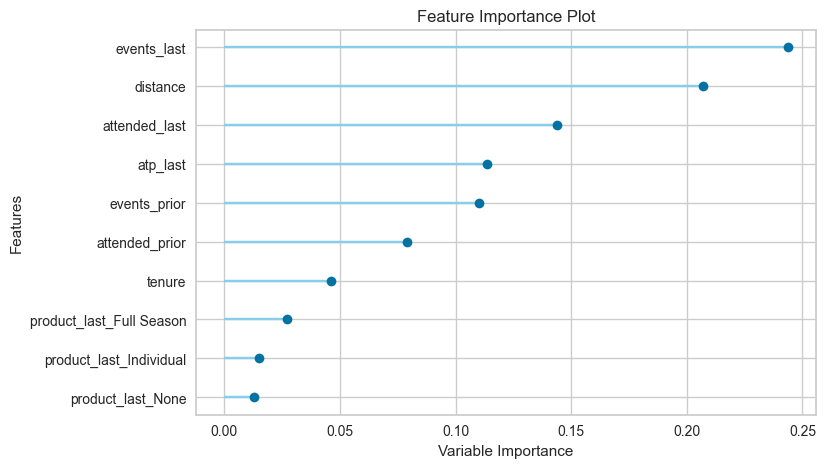

In [10]:
plot_model(final_model, plot='feature')

### Let's also look at the confusion matrix for hits and misses:

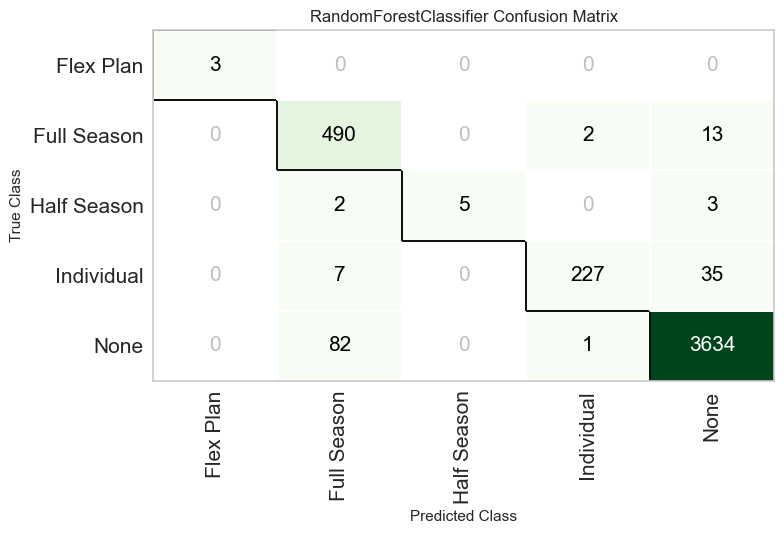

In [11]:
plot_model(final_model, plot="confusion_matrix")

### Let's save our model for future use:

### Let's load in our 2022 season data and get product propensity probabilities using the model:

In [12]:
df_inference = df.loc[df["seasonYear"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(31419, 13)

In [13]:
df_predictions = predict_model(final_model, data=df_inference)
df_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.0000,0.9908,0,0,0,0,0


,dimCustomerMasterId,email,ticketingid,distance,seasonYear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last,Label,Score
0,20,0160495@gmail.com,1129223,62.69,2023,1,1,1,1,0,33.00,None,Individual,None,1.00
1,22,01juliop@gmail.com,691152,4149.97,2023,1,1,1,1,0,20.00,None,Individual,None,1.00
3,23,01rodeo01@gmail.com,153794,25.94,2022,30,30,17,17,1,53.53,None,Full Season,None,0.61
4,23,01rodeo01@gmail.com,153794,25.94,2023,31,31,1,1,2,0.00,None,None,None,1.00
5,52,06guer1103@gmail.com,253859,3763.40,2022,17,6,17,6,0,37.58,Full Season,Full Season,Full Season,0.58


### Now we can see the count for each products in the inference data:

In [14]:
counts = df_predictions.Label.value_counts()
counts

None           28183
Individual      1905
Full Season     1296
Flex Plan         19
Half Season       16
Name: Label, dtype: int64

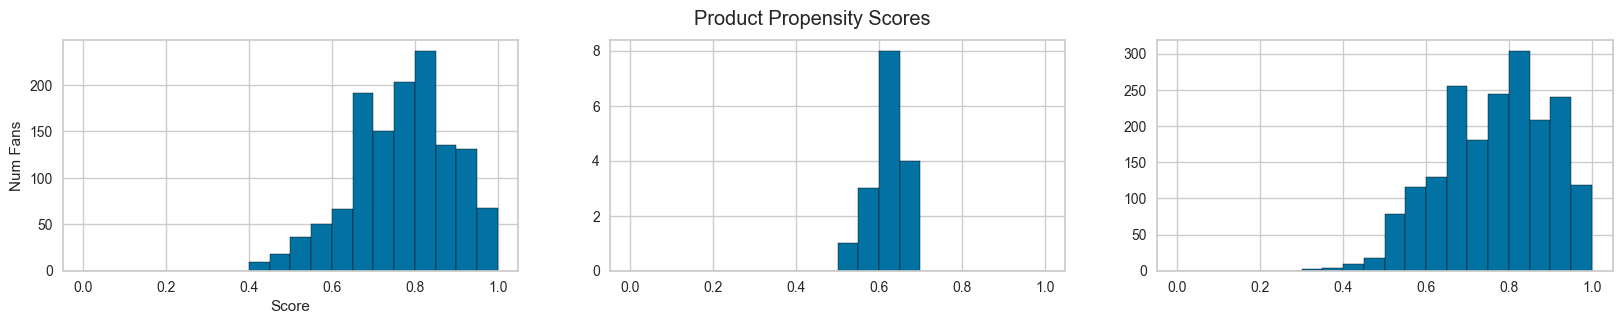

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

fig.suptitle("Product Propensity Scores")

ax1.hist(df_predictions[df_predictions.Label == "Full Season"].Score, bins=20,  edgecolor="black", range=(0,1))
ax2.hist(df_predictions[df_predictions.Label == "Half Season"].Score, bins=20, edgecolor="black", range=(0,1))
ax3.hist(df_predictions[df_predictions.Label == "Individual"].Score, bins=20, edgecolor="black", range=(0,1))

ax1.set_xlabel('Score')
ax1.set_ylabel('Num Fans')

plt.show()

In [16]:
df_predictions_fs = df_predictions[df_predictions.Label == "Full Season"]

df_predictions_fs_new = df_predictions_fs[df_predictions_fs.product_last != "Full Season"]

df_predictions_fs_new.shape

(41, 15)

### Let's export these scores to csv for further analysis:

In [17]:
current_date = datetime.today().strftime('%Y-%m-%d')
df_predictions.to_csv(f"./data/output/InterMiami_ProductPropensity_Scores_{current_date}.csv", index=False)

### Done